## Capstone Project
**Airbnb Pricing**
**Jin Zheng**
**2025/07**

### Index

- [Linear + Ridge + Lasso Regression with Grid Search](#-Model-1)
- [XGBoost Model](#-Model-2)
- [Support Vector Regression (SVR)](#-Model-3)
- [StackingRegressor: XGBoost + Ridge](#-Model-4)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("../data/airbnb_cleaned_top20_amenities.csv")

df = df.drop(columns=['id'])
target = 'log_price'

categorical_features = ['property_type', 'room_type', 'city', 'instant_bookable', 'zipcode']
numeric_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

known_columns = set(categorical_features + numeric_features + [target])
amenity_features = [col for col in df.columns if col not in known_columns]

In [4]:
X = df[categorical_features + numeric_features + amenity_features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[Back to top](#-Index)

### Model 1
**Linear + Ridge + Lasso Regression with Grid Search**

In [ ]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # leave binary amenity features unchanged
)


In [6]:
# Models with hyperparameter grids
models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            "model__alpha": np.logspace(-3, 3, 7)
        }
    },
    "Lasso": {
        "model": Lasso(max_iter=10000),
        "params": {
            "model__alpha": np.logspace(-3, 1, 10)
        }
    }
}


In [ ]:
# Train, tune, and evaluate
results = []

for name, cfg in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', cfg["model"])
    ])
    
    grid = GridSearchCV(pipeline, cfg["params"], cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R²": round(r2, 4)
    })

# 8. Show results
results_df = pd.DataFrame(results)
print(results_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


              Model              Best Params     MAE    RMSE      R²
0  LinearRegression                       {}  0.2803  0.3842  0.6914
1             Ridge    {'model__alpha': 1.0}  0.2799  0.3833  0.6929
2             Lasso  {'model__alpha': 0.001}  0.3094  0.4179  0.6350


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model Performance Comparison:


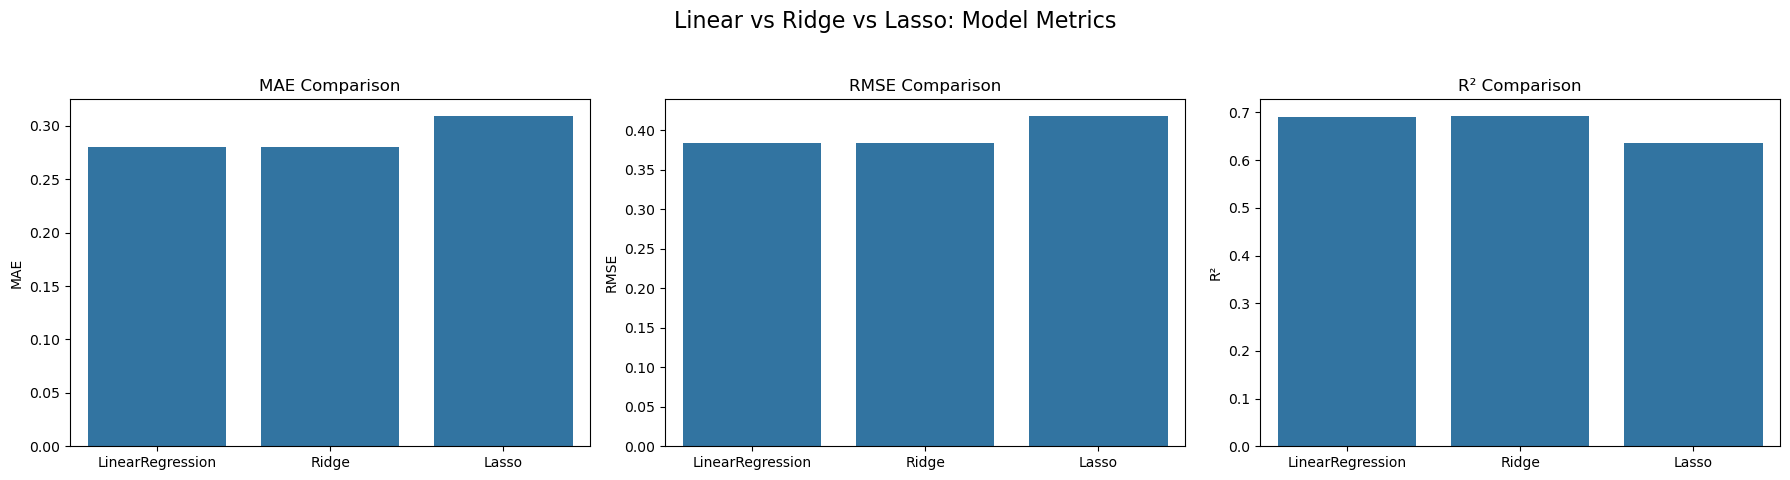

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Model Performance Comparison:")

# Plotting: MAE, RMSE, and R² comparison
metrics_to_plot = ['MAE', 'RMSE', 'R²']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(ax=axes[i], x='Model', y=metric, data=results_df)
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("")

plt.suptitle("Linear vs Ridge vs Lasso: Model Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("image/linear_ridge_lasso_model_metric_comparison.png")
plt.show()

[Back to top](#-Index)

### Model 2
**XGBoost Model**

In [12]:
import os
from xgboost import XGBRegressor, plot_importance

In [13]:
# XGBoost Regressor with GridSearchCV

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.1, 0.3],
    "model__subsample": [0.8, 1.0]
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb)
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['property_type',
                                                                          'room_type',
                                                                          'city',
                                                                          'instant_bookable',
                                                                          'zipcode']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.3],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [14]:
# Evaluate model
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Model Evaluation")
print("Best Parameters:", grid_search.best_params_)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

✅ XGBoost Model Evaluation
Best Parameters: {'model__learning_rate': 0.3, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
MAE:  0.2765
RMSE: 0.3780
R²:   0.7014


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


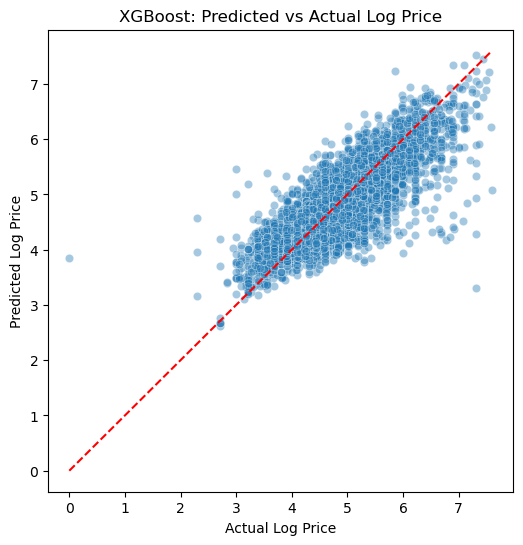

In [16]:
# Plot prediction error
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("XGBoost: Predicted vs Actual Log Price")
plt.savefig("image/xgboost_predicted_vs_actual.png")
plt.show()



<Figure size 1000x600 with 0 Axes>

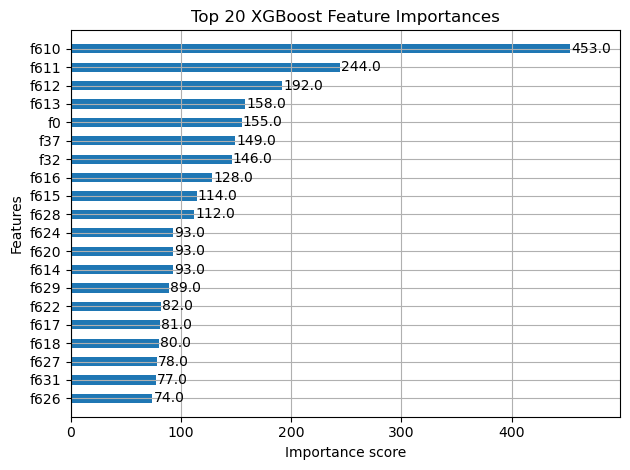

In [18]:
# Plot feature importance

xgb_params = {
    key.replace("model__", ""): val
    for key, val in grid_search.best_params_.items()
    if key.startswith("model__")
}
# Refit XGBoost model directly with best params
final_model = XGBRegressor(**xgb_params, objective='reg:squarederror')
X_preprocessed = preprocessor.fit_transform(X_train)
final_model.fit(X_preprocessed, y_train)

plt.figure(figsize=(10, 6))
plot_importance(final_model, max_num_features=20, height=0.5)
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.savefig("image/xgboost_feature_importances.png")
plt.show()

[Back to top](#-Index)

### Model 3
**Support Vector Regression (SVR)**

In [19]:
from sklearn.svm import SVR


In [20]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['property_type', 'room_type', 'city', 'instant_bookable', 'zipcode']),
    ('num', StandardScaler(), ['accommodates', 'bathrooms', 'bedrooms', 'beds'])
], remainder='passthrough')  # amenity binary features

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR())
])

In [21]:
param_grid = {
    'model__kernel': ['rbf'],
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__gamma': ['scale', 'auto']
}

svr_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['property_type',
                                                                          'room_type',
                                                                          'city',
                                                                          'instant_bookable',
                                                                          'zipcode']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds'])])),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__epsilon': [0.1, 0.2, 0.5],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [22]:
# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = svr_grid.predict(X_test)

print("✅ SVR Model Results")
print("Best Params:", svr_grid.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))

✅ SVR Model Results
Best Params: {'model__C': 1, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
MAE: 0.26660103920702793
RMSE: 0.37086539086178144
R²: 0.7125205518088684


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


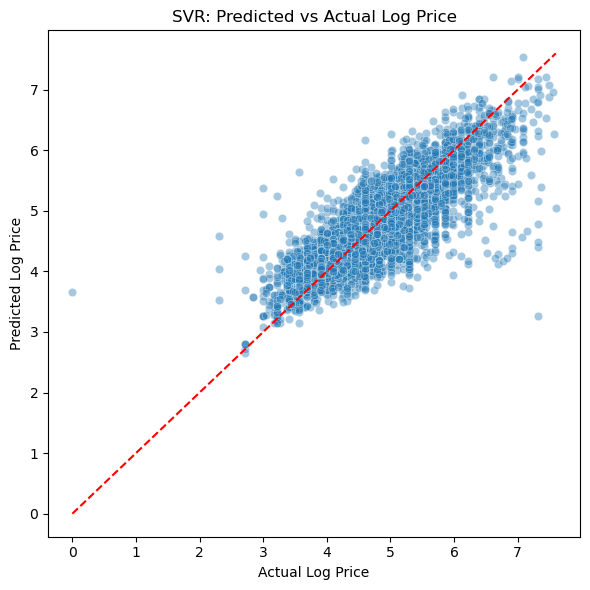

In [23]:
# Scatter plot of predicted vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("SVR: Predicted vs Actual Log Price")
plt.tight_layout()
plt.savefig("image/svr_predicted_vs_actual.png")
plt.show()

[Back to top](#-Index)

### Model 4
**StackingRegressor: XGBoost + Ridge**